# Proyecto
## Clasificación de Sonidos Urbanos

**Universidad del Valle de Guatemala**\
**Facultad de Ingeniería**\
**Departamento de Ciencias de la Computación**\
**Deep Learning**

---
### Integrantes:
- Diego Leiva
- Pablo Orellana
- Maria Marta Ramirez
---

## Librerias

In [1]:
# Datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut

# Torch
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Utils
import os
from tqdm import tqdm
import random
import platform

# Advertencias
import warnings
warnings.filterwarnings("ignore") # Ignorar advertencias

## Metadatos

In [2]:
AUDIO_PATH = 'data/UrbanSound8K/audio/'

# Obtencion de metadatos
metadata = pd.read_csv('data/UrbanSound8K/metadata/UrbanSound8K.csv')
files = metadata['slice_file_name'].values
labels = metadata['classID'].values
folds = metadata['fold'].values
classes = metadata['class'].values

# Creacion de directorios
paths = [
    os.path.join(AUDIO_PATH + f"fold{fold}", file) for fold, file in zip(folds, files)
]

# Crear y ordenar el diccionario de mapeo classID -> class
class_mapping = dict(sorted(metadata[['classID', 'class']].drop_duplicates().set_index('classID')['class'].to_dict().items()))

# Ver el mapeo resultante
print("-"*15, " Mapeo de clases ", "-"*15)
for key, value in class_mapping.items():
    print(f"{key}: {value}")


---------------  Mapeo de clases  ---------------
0: air_conditioner
1: car_horn
2: children_playing
3: dog_bark
4: drilling
5: engine_idling
6: gun_shot
7: jackhammer
8: siren
9: street_music


## Configuracion de PyTorch CUDA

In [3]:
# Semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Configuración de determinismo
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_info = ""

# Configuración de dispositivo
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    device_info = f'{torch.cuda.get_device_name(0)}'
else:
    device_info = f"{platform.processor()}"

print(f"Device: {device_info}")

Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU


## Dataset y Dataloader de Audio

In [4]:
class AudioDataset():
    def __init__(self, paths, labels, train=True):
        self.paths = paths
        self.labels = labels
        self.audio_length = 160000  # 4 segundos de audio
        self.train = train

        # Definir transformaciones con parámetros ajustados
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=22050,
            n_fft=2048,
            win_length=1024, 
            hop_length=512,  
            n_mels=128,     
            f_min=20,
            f_max=11025  # sample_rate/2
        )

        # Masking de la señal de audio
        self.time_masking = torchaudio.transforms.TimeMasking(time_mask_param=30)
        self.freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=20)
        

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        file = self.paths[idx]
        waveform, _ = torchaudio.load(file, normalize=True)
        mono = torch.mean(waveform, dim=0, keepdim=True)

        temp = torch.zeros([1, self.audio_length])
        if mono.numel() < self.audio_length:
            temp[:, :mono.numel()] = mono
        else:
            temp = mono[:, :self.audio_length]

        # Asignar audio mono 
        audio_mono = temp

        # Obtener espectrograma de Mel
        mel_spectrogram = self.mel_spec(audio_mono)

        # Aplicar masking en training
        if self.train:
            mel_spectrogram = self.time_masking(mel_spectrogram)
            mel_spectrogram = self.freq_masking(mel_spectrogram)
            
        # Normalización más robusta
        mel_spectrogram_norm = (mel_spectrogram - mel_spectrogram.mean()) / (mel_spectrogram.std() + 1e-7)


        feature_dict = {
            'feature_vector': mel_spectrogram_norm[0].permute(1, 0).clone().detach(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        
        return feature_dict

In [5]:
def collate_data(data):
    # Inicializar listas de features y labels
    features = []
    labels = []

    # Iterar sobre los datos
    for element in data:
        # Extraer feature y label
        feature = element["feature_vector"].to(device)
        label = element["label"].to(device)

        # Agregar a las listas
        features.append(feature)
        labels.append(label)

    # Realizar padding de los features y convertir labels a tensor
    feature = nn.utils.rnn.pad_sequence(features, batch_first=True, padding_value=0.)
    labels = torch.stack(labels).long()  # Asegurar que labels sea Long

    return feature, labels

## Modelo LSTM

In [6]:
class AudioLSTM(nn.Module):
    def __init__(self, feature_size, out_features, hidden_layers, layers, dropout):
        super().__init__()
        self.n_hidden = hidden_layers
        self.n_layers = layers
        self.n_feature = feature_size

        # Capa LSTM
        self.lstm = nn.LSTM(
            input_size=self.n_feature,
            hidden_size=self.n_hidden,
            num_layers=self.n_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=True
        )

        # Aplicar mecanismo de atención
        self.attention = nn.Sequential(
            nn.Linear(self.n_hidden * 2, self.n_hidden),
            nn.Tanh(),
            nn.Linear(self.n_hidden, 1)
        )

        # Capa de dropout
        self.dropout = nn.Dropout(dropout)

        # Primer capa lineal con batch normalization
        self.fc1 = nn.Linear(self.n_hidden * 2, self.n_hidden)
        self.batch_norm1 = nn.BatchNorm1d(self.n_hidden)
        
        # Segunda capa lineal con batch normalization
        self.fc2 = nn.Linear(self.n_hidden, int(self.n_hidden/2))
        self.batch_norm2 = nn.BatchNorm1d(int(self.n_hidden/2))
        
        # Capa de salida
        self.fc3 = nn.Linear(int(self.n_hidden/2), out_features)

    # Attention mechanism
    def attention_net(self, lstm_output):
        # Obtener el tamaño de la secuencia 
        attention_weights = self.attention(lstm_output)
        attention_weights = F.softmax(attention_weights, dim=1)

        # Aplicar atención a la salida de la LSTM
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector

    # Forward pass
    def forward(self, x, hidden):
        # X shape -> (batch_size, sequence_length, n_features)
        # Salida de la capa LSTM
        l_out, l_hidden = self.lstm(x, hidden)

        # Aplicar mecanismo de atención
        attn_out = self.attention_net(l_out)

        # Out shape -> (batch_size, sequence_length, n_hidden*direcction)
        # Aplicar Dropout a la salida de la capa LSTM
        out = self.dropout(attn_out)
        
        identity = out
        # Paso a través de la primera capa lineal
        out = self.fc1(out) # Tomar la salida de la capa LSTM con atención
        out = self.batch_norm1(out)  # Aplicar batch normalization

        # Aplicar función de activación ReLU
        out = F.relu(out)

        # Paso a través de la segunda capa lineal
        out = self.fc2(out)
        out = self.batch_norm2(out)

        # Aplicar función de activación ReLU
        out = F.relu(out)

        # Aplicar dropout
        out = self.dropout(out)

        # Paso a través de la capa de salida
        out = self.fc3(out)
        
        # Retornar el output y el hidden state
        return out, l_hidden
    

    # Inicializar hidden state
    def init_hidden(self, batch_size):
        # Obtener pesos de la primera capa
        weight = next(self.parameters()).data

        # Inicializar hidden state con ceros
        hidden = (weight.new(self.n_layers * 2, batch_size, self.n_hidden).zero_().to(device),
                  weight.new(self.n_layers * 2, batch_size, self.n_hidden).zero_().to(device))
        
        # Retornar hidden state
        return hidden

In [7]:
def save_model(state, path):
    torch.save(state, path)

### Loop de entrenamiento

In [8]:
def train_model(data_loader, model, epoch, optimizer, device):
    # Inicializar lista de perdidas, accuracy, labels y predicciones
    losses = []
    labels = []
    predictions = []

    # Establecer modelo en modo de entrenamiento
    model.train()

    # Crear barra de progreso
    loop = tqdm(data_loader)

    # Iterar sobre los datos
    for batch_idx, (data, target) in enumerate(loop):
        # Enviar datos al dispositivo
        data = data.to(device)
        target = target.to(device)

        # Limpiar gradientes
        model.zero_grad()

        # Inicializar hidden state y output
        output, _ = model(data, model.init_hidden(data.size(0)))
        
        # Calcular perdida
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward() # Backpropagation

        # Optimizar
        optimizer.step()

        # Agregar perdida
        losses.append(loss.item())
        
        # Obtener mayor valor de output
        winners = output.argmax(dim=1)
        
        # Agregar labels y predicciones
        labels += torch.flatten(target).cpu().tolist()
        predictions += torch.flatten(winners).cpu().tolist()

        # Calcular accuracy del batch
        batch_accuracy = (winners == target).sum().float() / float(target.size(0))

        # Actualizar barra de progreso
        loop.set_description(f"TRAIN -> Epoch {epoch} | Batch: {batch_idx+1}/{len(data_loader)} | Loss: {loss.item():.4f} | Accuracy: {batch_accuracy:.4f}")

    # Obtener promedio de perdidas y accuracy total del epoch
    total_loss = np.mean(losses)
    total_accuracy = np.mean(np.array(labels) == np.array(predictions))

    # Obterner reporte de clasificacion de la epoch
    train_report = classification_report(labels, predictions, output_dict=True)
    # Obtener matriz de confusion de la epoch
    train_confusion_matrix = confusion_matrix(labels, predictions)

    # Imprimir métricas finales usando tqdm.write
    tqdm.write(f"TRAIN -> Epoch {epoch} | Final Loss: {total_loss:.4f} | Final Accuracy: {total_accuracy:.4f}")

    # Retornar perdida, accuracy, reporte y matriz de la epoca
    return total_loss, total_accuracy, train_confusion_matrix, train_report

### Loop de Validacion

In [9]:
def validate(data_loader, model, device):
    # Inicializar lista de perdidas, accuracy, labels
    losses = []
    labels = []
    predictions = []
    
    # Configurar modelo en modo de evaluacion
    model.eval()

    # Sin actualizar gradientes
    with torch.no_grad():
        # Crear barra de progreso
        loop = tqdm(data_loader)

        # Iterar sobre los datos
        for batch_idx, (data, target) in enumerate(loop):
            # Enviar datos al dispositivo
            data = data.to(device)
            target = target.to(device)

            # Inicializar hidden state y output
            output, _ = model(data, model.init_hidden(data.size(0)))

            # Calcular perdida
            loss = nn.CrossEntropyLoss()(output, target)
            # Agregar perdida
            losses.append(loss.item())

            # Obtener mayor valor de output
            winners = output.argmax(dim=1)

            # Agregar lables y predicciones
            labels += torch.flatten(target).cpu()
            predictions += torch.flatten(winners).cpu()

            # Calcular accuracy
            batch_accuracy = (winners == target).sum().float() / float(target.size(0))

            loop.set_description(f"VALIDATE -> Batch: {batch_idx+1}/{len(data_loader)} | Accuracy: {batch_accuracy:.4f}")

    # Calcular accuracy total de toda la época de validación
    total_accuracy = np.mean(np.array(labels) == np.array(predictions))
    # Obtener promedio de perdidas de la época de validación
    total_loss = np.mean(losses)

    # Obtener reporte de clasificación de la época de validación
    val_report = classification_report(labels, predictions, output_dict=True)
    # Obtener matriz de confusión de la época de validación
    val_confusion_matrix = confusion_matrix(labels, predictions)

    # Imprimir métricas finales usando tqdm.write
    tqdm.write(f"VALIDATE -> Final Loss: {total_loss:.4f} | Final Accuracy: {total_accuracy:.4f}")


    # Retornar perdida, accuracy, reporte y matriz de la época de validación
    return total_loss, total_accuracy, val_confusion_matrix, val_report

## Configuracion inicial

In [10]:
# Constantes
EPOCHS = 50 # Numero de epocas
OUT_FEATURE = 10 # Numero de clases
SCHEDULER_PATIENCE = 5 # Paciencia para el scheduler
FEATURE_SIZE = 128 # Tamaño de los features (n_mels)

## Loop Principal

En este loop se hacen los splits train-test para los 10 Folds, de esta manera se entrena el modelo con 9 Folds y se Valida con el Sobrante. Obteniendo metricas de rendimiento para la mejor epoca en cada Fold.

In [11]:
# Leave One Group Out Cross Validation
logo = LeaveOneGroupOut()

# Lista de diccionarios de Rendimiento de cada fold
folds_performance = []

# Loop de entrenamiento por epocas y folds
for fold_idx, (train_idx, val_idx) in enumerate(logo.split(paths, labels, folds)):
    
    # Diccionario de resultados del fold actual
    results = {
        'fold': fold_idx + 1,
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'train_report': None,
        'val_report': None,
        'train_matrix': None,
        'val_matrix': None,
        'best_accuracy': 0,
        'best_epoch': 0
    }

    # Imprimir separador si no es el primer fold
    if fold_idx > 0:
        print(f"\n")
    
    print("-"*15, f" FOLD {fold_idx+1} ", "-"*15)

    # Dividir datos en train y validation sets
    train_paths = [paths[i] for i in train_idx]
    val_paths = [paths[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    # Crear datasets
    train_dataset = AudioDataset(train_paths, train_labels, train=True)
    val_dataset = AudioDataset(val_paths, val_labels, train=False)

    # Crear dataloaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, collate_fn=collate_data)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_data)

    # Entrenamiento del Modelo
    model = AudioLSTM(feature_size=FEATURE_SIZE, 
                      out_features=OUT_FEATURE, 
                      hidden_layers=256, 
                      layers=2, 
                      dropout=0.3).to(device)
    
    # Crear optimizador AdamW y scheduler
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3) # Peso decaimiento
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=SCHEDULER_PATIENCE, factor=0.1) # Reducir tasa de aprendizaje

    # Loop de entrenamiento
    for epoch in range(EPOCHS):
        
        # Entrenar modelo y obtener perdidas y accuracy
        epoch_train_loss, epoch_train_acc, epoch_train_matrix, epoch_train_report = train_model(train_loader, model, epoch, optimizer, device)

        # Validar modelo y obtener accuracy
        epoch_val_loss, epoch_val_acc, epoch_val_matrix, epoch_val_report = validate(val_loader, model, device)

        # Guardar perdidas y accuracies del epoch actual
        results['train_losses'].append(epoch_train_loss)
        results['val_losses'].append(epoch_val_loss)
        results['train_accuracies'].append(epoch_train_acc)
        results['val_accuracies'].append(epoch_val_acc)
        
        # Actualizar el scheduler y guardar el mejor modelo
        scheduler.step(epoch_train_acc)
        
        # Guardar el mejor modelo y metricas de desempeño para el fold actual
        if epoch_val_acc > results['best_accuracy']:
            # Resetear contador de paciencia
            no_improvement = 0

            # Actualizar mejor accuracy y epoch
            results['best_accuracy'] = epoch_val_acc
            results['best_epoch'] = epoch
            
            # Actualizar reportes y matrices
            results['train_report'] = epoch_train_report
            results['val_report'] = epoch_val_report
            results['train_matrix'] = epoch_train_matrix
            results['val_matrix'] = epoch_val_matrix

            # Guardar mejor modelo hasta ahora
            save_model({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'models/lstmv2_fold{fold_idx + 1}.pth')

    # Terminar fold y guardar resultados
    folds_performance.append(results)

---------------  FOLD 1  ---------------


TRAIN -> Epoch 0 | Batch: 62/62 | Loss: 2.1130 | Accuracy: 0.2941: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


TRAIN -> Epoch 0 | Final Loss: 2.1124 | Final Accuracy: 0.2741


VALIDATE -> Batch: 7/7 | Accuracy: 0.4667: 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


VALIDATE -> Final Loss: 1.8188 | Final Accuracy: 0.3677


TRAIN -> Epoch 1 | Batch: 62/62 | Loss: 1.9714 | Accuracy: 0.3137: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9506 | Final Accuracy: 0.3123


VALIDATE -> Batch: 7/7 | Accuracy: 0.4952: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


VALIDATE -> Final Loss: 1.6952 | Final Accuracy: 0.4032


TRAIN -> Epoch 2 | Batch: 62/62 | Loss: 1.8880 | Accuracy: 0.3922: 100%|██████████| 62/62 [00:35<00:00,  1.77it/s]


TRAIN -> Epoch 2 | Final Loss: 1.8680 | Final Accuracy: 0.3471


VALIDATE -> Batch: 7/7 | Accuracy: 0.5429: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


VALIDATE -> Final Loss: 1.6108 | Final Accuracy: 0.4330


TRAIN -> Epoch 3 | Batch: 62/62 | Loss: 1.4370 | Accuracy: 0.4902: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


TRAIN -> Epoch 3 | Final Loss: 1.7636 | Final Accuracy: 0.3959


VALIDATE -> Batch: 7/7 | Accuracy: 0.5619: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


VALIDATE -> Final Loss: 1.5390 | Final Accuracy: 0.4651


TRAIN -> Epoch 4 | Batch: 62/62 | Loss: 1.2874 | Accuracy: 0.6275: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


TRAIN -> Epoch 4 | Final Loss: 1.6907 | Final Accuracy: 0.4228


VALIDATE -> Batch: 7/7 | Accuracy: 0.6095: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


VALIDATE -> Final Loss: 1.5542 | Final Accuracy: 0.5063


TRAIN -> Epoch 5 | Batch: 62/62 | Loss: 1.2179 | Accuracy: 0.7059: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


TRAIN -> Epoch 5 | Final Loss: 1.6126 | Final Accuracy: 0.4685


VALIDATE -> Batch: 7/7 | Accuracy: 0.6190: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


VALIDATE -> Final Loss: 1.4971 | Final Accuracy: 0.4822


TRAIN -> Epoch 6 | Batch: 62/62 | Loss: 0.9330 | Accuracy: 0.8235: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


TRAIN -> Epoch 6 | Final Loss: 1.5399 | Final Accuracy: 0.4927


VALIDATE -> Batch: 7/7 | Accuracy: 0.5810: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


VALIDATE -> Final Loss: 1.4096 | Final Accuracy: 0.5292


TRAIN -> Epoch 7 | Batch: 62/62 | Loss: 0.8773 | Accuracy: 0.8627: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


TRAIN -> Epoch 7 | Final Loss: 1.4627 | Final Accuracy: 0.5218


VALIDATE -> Batch: 7/7 | Accuracy: 0.6952: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


VALIDATE -> Final Loss: 1.3462 | Final Accuracy: 0.5361


TRAIN -> Epoch 8 | Batch: 62/62 | Loss: 0.7752 | Accuracy: 0.8824: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


TRAIN -> Epoch 8 | Final Loss: 1.3772 | Final Accuracy: 0.5478


VALIDATE -> Batch: 7/7 | Accuracy: 0.5810: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


VALIDATE -> Final Loss: 1.3973 | Final Accuracy: 0.5487


TRAIN -> Epoch 9 | Batch: 62/62 | Loss: 0.6367 | Accuracy: 0.9020: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


TRAIN -> Epoch 9 | Final Loss: 1.3064 | Final Accuracy: 0.5837


VALIDATE -> Batch: 7/7 | Accuracy: 0.6762: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


VALIDATE -> Final Loss: 1.3407 | Final Accuracy: 0.5934


TRAIN -> Epoch 10 | Batch: 62/62 | Loss: 0.6194 | Accuracy: 0.9020: 100%|██████████| 62/62 [01:10<00:00,  1.14s/it]


TRAIN -> Epoch 10 | Final Loss: 1.2436 | Final Accuracy: 0.5975


VALIDATE -> Batch: 7/7 | Accuracy: 0.6571: 100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


VALIDATE -> Final Loss: 1.2768 | Final Accuracy: 0.6231


TRAIN -> Epoch 11 | Batch: 62/62 | Loss: 0.5809 | Accuracy: 0.8824: 100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


TRAIN -> Epoch 11 | Final Loss: 1.1718 | Final Accuracy: 0.6282


VALIDATE -> Batch: 7/7 | Accuracy: 0.6762: 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


VALIDATE -> Final Loss: 1.3410 | Final Accuracy: 0.5647


TRAIN -> Epoch 12 | Batch: 62/62 | Loss: 0.5263 | Accuracy: 0.9412: 100%|██████████| 62/62 [02:07<00:00,  2.05s/it]


TRAIN -> Epoch 12 | Final Loss: 1.1162 | Final Accuracy: 0.6500


VALIDATE -> Batch: 7/7 | Accuracy: 0.6857: 100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


VALIDATE -> Final Loss: 1.3062 | Final Accuracy: 0.6231


TRAIN -> Epoch 13 | Batch: 62/62 | Loss: 0.4613 | Accuracy: 0.9216: 100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


TRAIN -> Epoch 13 | Final Loss: 1.0350 | Final Accuracy: 0.6792


VALIDATE -> Batch: 7/7 | Accuracy: 0.7143: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


VALIDATE -> Final Loss: 1.3726 | Final Accuracy: 0.5785


TRAIN -> Epoch 14 | Batch: 62/62 | Loss: 0.3859 | Accuracy: 0.9804: 100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


TRAIN -> Epoch 14 | Final Loss: 0.9617 | Final Accuracy: 0.7043


VALIDATE -> Batch: 7/7 | Accuracy: 0.7048: 100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


VALIDATE -> Final Loss: 1.2830 | Final Accuracy: 0.5911


TRAIN -> Epoch 15 | Batch: 62/62 | Loss: 0.2999 | Accuracy: 0.9608: 100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


TRAIN -> Epoch 15 | Final Loss: 0.9244 | Final Accuracy: 0.7192


VALIDATE -> Batch: 7/7 | Accuracy: 0.6762: 100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


VALIDATE -> Final Loss: 1.3228 | Final Accuracy: 0.5670


TRAIN -> Epoch 16 | Batch: 62/62 | Loss: 0.3857 | Accuracy: 0.9412: 100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


TRAIN -> Epoch 16 | Final Loss: 0.8469 | Final Accuracy: 0.7442


VALIDATE -> Batch: 7/7 | Accuracy: 0.6667: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


VALIDATE -> Final Loss: 1.3576 | Final Accuracy: 0.5338


TRAIN -> Epoch 17 | Batch: 62/62 | Loss: 0.2780 | Accuracy: 0.9608: 100%|██████████| 62/62 [02:08<00:00,  2.07s/it]


TRAIN -> Epoch 17 | Final Loss: 0.7860 | Final Accuracy: 0.7665


VALIDATE -> Batch: 7/7 | Accuracy: 0.6857: 100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


VALIDATE -> Final Loss: 1.3336 | Final Accuracy: 0.5739


TRAIN -> Epoch 18 | Batch: 62/62 | Loss: 0.5587 | Accuracy: 0.8824: 100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


TRAIN -> Epoch 18 | Final Loss: 0.7239 | Final Accuracy: 0.7804


VALIDATE -> Batch: 7/7 | Accuracy: 0.6762: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


VALIDATE -> Final Loss: 1.3306 | Final Accuracy: 0.5693


TRAIN -> Epoch 19 | Batch: 62/62 | Loss: 0.2445 | Accuracy: 0.9412: 100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


TRAIN -> Epoch 19 | Final Loss: 0.6853 | Final Accuracy: 0.8023


VALIDATE -> Batch: 7/7 | Accuracy: 0.6762: 100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


VALIDATE -> Final Loss: 1.4616 | Final Accuracy: 0.5441


TRAIN -> Epoch 20 | Batch: 62/62 | Loss: 0.2511 | Accuracy: 0.9608: 100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


TRAIN -> Epoch 20 | Final Loss: 0.6150 | Final Accuracy: 0.8219


VALIDATE -> Batch: 7/7 | Accuracy: 0.6476: 100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


VALIDATE -> Final Loss: 1.5336 | Final Accuracy: 0.5567


TRAIN -> Epoch 21 | Batch: 62/62 | Loss: 0.1437 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:12<00:00,  2.14s/it]


TRAIN -> Epoch 21 | Final Loss: 0.5612 | Final Accuracy: 0.8421


VALIDATE -> Batch: 7/7 | Accuracy: 0.6095: 100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


VALIDATE -> Final Loss: 1.7078 | Final Accuracy: 0.4639


TRAIN -> Epoch 22 | Batch: 62/62 | Loss: 0.1303 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


TRAIN -> Epoch 22 | Final Loss: 0.5169 | Final Accuracy: 0.8534


VALIDATE -> Batch: 7/7 | Accuracy: 0.6667: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


VALIDATE -> Final Loss: 1.5847 | Final Accuracy: 0.5533


TRAIN -> Epoch 23 | Batch: 62/62 | Loss: 0.2622 | Accuracy: 0.9608: 100%|██████████| 62/62 [02:10<00:00,  2.11s/it]


TRAIN -> Epoch 23 | Final Loss: 0.4989 | Final Accuracy: 0.8584


VALIDATE -> Batch: 7/7 | Accuracy: 0.6381: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


VALIDATE -> Final Loss: 1.6405 | Final Accuracy: 0.4880


TRAIN -> Epoch 24 | Batch: 62/62 | Loss: 0.0883 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


TRAIN -> Epoch 24 | Final Loss: 0.4476 | Final Accuracy: 0.8798


VALIDATE -> Batch: 7/7 | Accuracy: 0.6000: 100%|██████████| 7/7 [00:13<00:00,  2.00s/it]


VALIDATE -> Final Loss: 1.5378 | Final Accuracy: 0.5590


TRAIN -> Epoch 25 | Batch: 62/62 | Loss: 0.0946 | Accuracy: 0.9804: 100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


TRAIN -> Epoch 25 | Final Loss: 0.4112 | Final Accuracy: 0.8842


VALIDATE -> Batch: 7/7 | Accuracy: 0.6381: 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


VALIDATE -> Final Loss: 1.4753 | Final Accuracy: 0.5441


TRAIN -> Epoch 26 | Batch: 62/62 | Loss: 0.2220 | Accuracy: 0.9216: 100%|██████████| 62/62 [02:05<00:00,  2.03s/it]


TRAIN -> Epoch 26 | Final Loss: 0.3801 | Final Accuracy: 0.8953


VALIDATE -> Batch: 7/7 | Accuracy: 0.6762: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


VALIDATE -> Final Loss: 1.4335 | Final Accuracy: 0.5624


TRAIN -> Epoch 27 | Batch: 62/62 | Loss: 0.0584 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:11<00:00,  2.11s/it]


TRAIN -> Epoch 27 | Final Loss: 0.3304 | Final Accuracy: 0.9088


VALIDATE -> Batch: 7/7 | Accuracy: 0.6667: 100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


VALIDATE -> Final Loss: 1.5364 | Final Accuracy: 0.5407


TRAIN -> Epoch 28 | Batch: 62/62 | Loss: 0.1477 | Accuracy: 0.9608: 100%|██████████| 62/62 [02:11<00:00,  2.13s/it]


TRAIN -> Epoch 28 | Final Loss: 0.3430 | Final Accuracy: 0.9079


VALIDATE -> Batch: 7/7 | Accuracy: 0.6286: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


VALIDATE -> Final Loss: 1.5487 | Final Accuracy: 0.5384


TRAIN -> Epoch 29 | Batch: 62/62 | Loss: 0.1291 | Accuracy: 0.9608: 100%|██████████| 62/62 [02:11<00:00,  2.12s/it]


TRAIN -> Epoch 29 | Final Loss: 0.2819 | Final Accuracy: 0.9254


VALIDATE -> Batch: 7/7 | Accuracy: 0.6667: 100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


VALIDATE -> Final Loss: 1.5427 | Final Accuracy: 0.5498


TRAIN -> Epoch 30 | Batch: 62/62 | Loss: 0.0945 | Accuracy: 0.9804: 100%|██████████| 62/62 [02:12<00:00,  2.14s/it]


TRAIN -> Epoch 30 | Final Loss: 0.2793 | Final Accuracy: 0.9224


VALIDATE -> Batch: 7/7 | Accuracy: 0.6571: 100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


VALIDATE -> Final Loss: 1.5865 | Final Accuracy: 0.5510


TRAIN -> Epoch 31 | Batch: 62/62 | Loss: 0.0668 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:10<00:00,  2.11s/it]


TRAIN -> Epoch 31 | Final Loss: 0.2611 | Final Accuracy: 0.9307


VALIDATE -> Batch: 7/7 | Accuracy: 0.6571: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]


VALIDATE -> Final Loss: 1.6281 | Final Accuracy: 0.5395


TRAIN -> Epoch 32 | Batch: 62/62 | Loss: 0.0276 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


TRAIN -> Epoch 32 | Final Loss: 0.2213 | Final Accuracy: 0.9397


VALIDATE -> Batch: 7/7 | Accuracy: 0.6762: 100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


VALIDATE -> Final Loss: 1.6441 | Final Accuracy: 0.5372


TRAIN -> Epoch 33 | Batch: 62/62 | Loss: 0.0756 | Accuracy: 0.9804: 100%|██████████| 62/62 [02:10<00:00,  2.11s/it]


TRAIN -> Epoch 33 | Final Loss: 0.2279 | Final Accuracy: 0.9377


VALIDATE -> Batch: 7/7 | Accuracy: 0.7429: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


VALIDATE -> Final Loss: 1.5102 | Final Accuracy: 0.5911


TRAIN -> Epoch 34 | Batch: 62/62 | Loss: 0.0106 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:11<00:00,  2.12s/it]


TRAIN -> Epoch 34 | Final Loss: 0.2013 | Final Accuracy: 0.9481


VALIDATE -> Batch: 7/7 | Accuracy: 0.6762: 100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


VALIDATE -> Final Loss: 1.6462 | Final Accuracy: 0.5533


TRAIN -> Epoch 35 | Batch: 62/62 | Loss: 0.0519 | Accuracy: 0.9804: 100%|██████████| 62/62 [02:07<00:00,  2.06s/it]


TRAIN -> Epoch 35 | Final Loss: 0.1869 | Final Accuracy: 0.9494


VALIDATE -> Batch: 7/7 | Accuracy: 0.7143: 100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


VALIDATE -> Final Loss: 1.5765 | Final Accuracy: 0.5487


TRAIN -> Epoch 36 | Batch: 62/62 | Loss: 0.0241 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:11<00:00,  2.11s/it]


TRAIN -> Epoch 36 | Final Loss: 0.1850 | Final Accuracy: 0.9514


VALIDATE -> Batch: 7/7 | Accuracy: 0.7524: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]


VALIDATE -> Final Loss: 1.5599 | Final Accuracy: 0.5842


TRAIN -> Epoch 37 | Batch: 62/62 | Loss: 0.0341 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:09<00:00,  2.09s/it]


TRAIN -> Epoch 37 | Final Loss: 0.1966 | Final Accuracy: 0.9453


VALIDATE -> Batch: 7/7 | Accuracy: 0.7333: 100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


VALIDATE -> Final Loss: 1.5368 | Final Accuracy: 0.5636


TRAIN -> Epoch 38 | Batch: 62/62 | Loss: 0.0324 | Accuracy: 0.9804: 100%|██████████| 62/62 [02:12<00:00,  2.14s/it]


TRAIN -> Epoch 38 | Final Loss: 0.1951 | Final Accuracy: 0.9454


VALIDATE -> Batch: 7/7 | Accuracy: 0.7048: 100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


VALIDATE -> Final Loss: 1.6203 | Final Accuracy: 0.5567


TRAIN -> Epoch 39 | Batch: 62/62 | Loss: 0.0473 | Accuracy: 0.9804: 100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


TRAIN -> Epoch 39 | Final Loss: 0.1581 | Final Accuracy: 0.9564


VALIDATE -> Batch: 7/7 | Accuracy: 0.7619: 100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


VALIDATE -> Final Loss: 1.7554 | Final Accuracy: 0.5808


TRAIN -> Epoch 40 | Batch: 62/62 | Loss: 0.1614 | Accuracy: 0.9608: 100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


TRAIN -> Epoch 40 | Final Loss: 0.1285 | Final Accuracy: 0.9679


VALIDATE -> Batch: 7/7 | Accuracy: 0.7333: 100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


VALIDATE -> Final Loss: 1.6145 | Final Accuracy: 0.5865


TRAIN -> Epoch 41 | Batch: 62/62 | Loss: 0.0208 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:10<00:00,  2.10s/it]


TRAIN -> Epoch 41 | Final Loss: 0.1490 | Final Accuracy: 0.9602


VALIDATE -> Batch: 7/7 | Accuracy: 0.6857: 100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


VALIDATE -> Final Loss: 1.4661 | Final Accuracy: 0.6071


TRAIN -> Epoch 42 | Batch: 62/62 | Loss: 0.0609 | Accuracy: 0.9804: 100%|██████████| 62/62 [02:09<00:00,  2.08s/it]


TRAIN -> Epoch 42 | Final Loss: 0.1358 | Final Accuracy: 0.9650


VALIDATE -> Batch: 7/7 | Accuracy: 0.7333: 100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


VALIDATE -> Final Loss: 1.5516 | Final Accuracy: 0.6140


TRAIN -> Epoch 43 | Batch: 62/62 | Loss: 0.0152 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:08<00:00,  2.08s/it]


TRAIN -> Epoch 43 | Final Loss: 0.1264 | Final Accuracy: 0.9678


VALIDATE -> Batch: 7/7 | Accuracy: 0.7429: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


VALIDATE -> Final Loss: 1.7445 | Final Accuracy: 0.5578


TRAIN -> Epoch 44 | Batch: 62/62 | Loss: 0.0207 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:11<00:00,  2.11s/it]


TRAIN -> Epoch 44 | Final Loss: 0.1085 | Final Accuracy: 0.9726


VALIDATE -> Batch: 7/7 | Accuracy: 0.7048: 100%|██████████| 7/7 [00:14<00:00,  2.01s/it]


VALIDATE -> Final Loss: 1.5988 | Final Accuracy: 0.5704


TRAIN -> Epoch 45 | Batch: 62/62 | Loss: 0.0102 | Accuracy: 1.0000: 100%|██████████| 62/62 [02:10<00:00,  2.11s/it]


TRAIN -> Epoch 45 | Final Loss: 0.1052 | Final Accuracy: 0.9747


VALIDATE -> Batch: 7/7 | Accuracy: 0.7238: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


VALIDATE -> Final Loss: 1.4953 | Final Accuracy: 0.6060


TRAIN -> Epoch 46 | Batch: 62/62 | Loss: 0.0061 | Accuracy: 1.0000: 100%|██████████| 62/62 [00:44<00:00,  1.39it/s]


TRAIN -> Epoch 46 | Final Loss: 0.1045 | Final Accuracy: 0.9732


VALIDATE -> Batch: 7/7 | Accuracy: 0.6952: 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


VALIDATE -> Final Loss: 1.5233 | Final Accuracy: 0.6128


TRAIN -> Epoch 47 | Batch: 62/62 | Loss: 0.0081 | Accuracy: 1.0000: 100%|██████████| 62/62 [00:39<00:00,  1.59it/s]


TRAIN -> Epoch 47 | Final Loss: 0.1146 | Final Accuracy: 0.9691


VALIDATE -> Batch: 7/7 | Accuracy: 0.7143: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


VALIDATE -> Final Loss: 1.5381 | Final Accuracy: 0.5911


TRAIN -> Epoch 48 | Batch: 62/62 | Loss: 0.0508 | Accuracy: 0.9608: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


TRAIN -> Epoch 48 | Final Loss: 0.1043 | Final Accuracy: 0.9715


VALIDATE -> Batch: 7/7 | Accuracy: 0.7238: 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


VALIDATE -> Final Loss: 1.5047 | Final Accuracy: 0.5934


TRAIN -> Epoch 49 | Batch: 62/62 | Loss: 0.0244 | Accuracy: 1.0000: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


TRAIN -> Epoch 49 | Final Loss: 0.0957 | Final Accuracy: 0.9738


VALIDATE -> Batch: 7/7 | Accuracy: 0.6952: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


VALIDATE -> Final Loss: 1.3890 | Final Accuracy: 0.6323


---------------  FOLD 2  ---------------


TRAIN -> Epoch 0 | Batch: 62/62 | Loss: 1.9933 | Accuracy: 0.2222: 100%|██████████| 62/62 [00:34<00:00,  1.77it/s]


TRAIN -> Epoch 0 | Final Loss: 2.1284 | Final Accuracy: 0.2656


VALIDATE -> Batch: 7/7 | Accuracy: 0.2417: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


VALIDATE -> Final Loss: 1.7107 | Final Accuracy: 0.3863


TRAIN -> Epoch 1 | Batch: 62/62 | Loss: 1.5559 | Accuracy: 0.5278: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


TRAIN -> Epoch 1 | Final Loss: 1.9564 | Final Accuracy: 0.3191


VALIDATE -> Batch: 7/7 | Accuracy: 0.5417: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


VALIDATE -> Final Loss: 1.6121 | Final Accuracy: 0.4369


TRAIN -> Epoch 2 | Batch: 62/62 | Loss: 1.4437 | Accuracy: 0.5833: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


TRAIN -> Epoch 2 | Final Loss: 1.8284 | Final Accuracy: 0.3706


VALIDATE -> Batch: 7/7 | Accuracy: 0.3833: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.6340 | Final Accuracy: 0.4268


TRAIN -> Epoch 3 | Batch: 62/62 | Loss: 1.2150 | Accuracy: 0.6389: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


TRAIN -> Epoch 3 | Final Loss: 1.7372 | Final Accuracy: 0.4046


VALIDATE -> Batch: 7/7 | Accuracy: 0.3167: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.6537 | Final Accuracy: 0.4077


TRAIN -> Epoch 4 | Batch: 62/62 | Loss: 1.1517 | Accuracy: 0.6944: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


TRAIN -> Epoch 4 | Final Loss: 1.6663 | Final Accuracy: 0.4349


VALIDATE -> Batch: 7/7 | Accuracy: 0.3917: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.6836 | Final Accuracy: 0.4189


TRAIN -> Epoch 5 | Batch: 62/62 | Loss: 0.9041 | Accuracy: 0.8611: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


TRAIN -> Epoch 5 | Final Loss: 1.5858 | Final Accuracy: 0.4745


VALIDATE -> Batch: 7/7 | Accuracy: 0.4250: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.6375 | Final Accuracy: 0.4268


TRAIN -> Epoch 6 | Batch: 62/62 | Loss: 0.7822 | Accuracy: 0.8611: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


TRAIN -> Epoch 6 | Final Loss: 1.5070 | Final Accuracy: 0.5076


VALIDATE -> Batch: 7/7 | Accuracy: 0.4917: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.7319 | Final Accuracy: 0.4381


TRAIN -> Epoch 7 | Batch: 62/62 | Loss: 0.6145 | Accuracy: 0.8889: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


TRAIN -> Epoch 7 | Final Loss: 1.4302 | Final Accuracy: 0.5358


VALIDATE -> Batch: 7/7 | Accuracy: 0.4583: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


VALIDATE -> Final Loss: 1.7700 | Final Accuracy: 0.4493


TRAIN -> Epoch 8 | Batch: 62/62 | Loss: 0.5246 | Accuracy: 0.8889: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


TRAIN -> Epoch 8 | Final Loss: 1.3498 | Final Accuracy: 0.5686


VALIDATE -> Batch: 7/7 | Accuracy: 0.4167: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


VALIDATE -> Final Loss: 1.5854 | Final Accuracy: 0.4617


TRAIN -> Epoch 9 | Batch: 62/62 | Loss: 0.5220 | Accuracy: 0.9167: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


TRAIN -> Epoch 9 | Final Loss: 1.2658 | Final Accuracy: 0.6010


VALIDATE -> Batch: 7/7 | Accuracy: 0.3750: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


VALIDATE -> Final Loss: 1.5761 | Final Accuracy: 0.4583


TRAIN -> Epoch 10 | Batch: 62/62 | Loss: 0.4639 | Accuracy: 0.9167: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


TRAIN -> Epoch 10 | Final Loss: 1.2151 | Final Accuracy: 0.6152


VALIDATE -> Batch: 7/7 | Accuracy: 0.4000: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


VALIDATE -> Final Loss: 1.5132 | Final Accuracy: 0.5270


TRAIN -> Epoch 11 | Batch: 62/62 | Loss: 0.3925 | Accuracy: 0.9444: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


TRAIN -> Epoch 11 | Final Loss: 1.1405 | Final Accuracy: 0.6490


VALIDATE -> Batch: 7/7 | Accuracy: 0.5083: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.4701 | Final Accuracy: 0.5518


TRAIN -> Epoch 12 | Batch: 62/62 | Loss: 0.3550 | Accuracy: 0.9722: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


TRAIN -> Epoch 12 | Final Loss: 1.0684 | Final Accuracy: 0.6777


VALIDATE -> Batch: 7/7 | Accuracy: 0.4917: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.5845 | Final Accuracy: 0.4899


TRAIN -> Epoch 13 | Batch: 62/62 | Loss: 0.3335 | Accuracy: 0.9444: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


TRAIN -> Epoch 13 | Final Loss: 0.9993 | Final Accuracy: 0.7051


VALIDATE -> Batch: 7/7 | Accuracy: 0.5333: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


VALIDATE -> Final Loss: 1.5816 | Final Accuracy: 0.5113


TRAIN -> Epoch 14 | Batch: 62/62 | Loss: 0.2503 | Accuracy: 0.9722: 100%|██████████| 62/62 [00:34<00:00,  1.77it/s]


TRAIN -> Epoch 14 | Final Loss: 0.9333 | Final Accuracy: 0.7245


VALIDATE -> Batch: 7/7 | Accuracy: 0.4167: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


VALIDATE -> Final Loss: 1.7014 | Final Accuracy: 0.5045


TRAIN -> Epoch 15 | Batch: 62/62 | Loss: 0.1939 | Accuracy: 0.9722: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


TRAIN -> Epoch 15 | Final Loss: 0.8663 | Final Accuracy: 0.7462


VALIDATE -> Batch: 7/7 | Accuracy: 0.5333: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


VALIDATE -> Final Loss: 1.6181 | Final Accuracy: 0.5135


TRAIN -> Epoch 16 | Batch: 62/62 | Loss: 0.1730 | Accuracy: 1.0000: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


TRAIN -> Epoch 16 | Final Loss: 0.7926 | Final Accuracy: 0.7750


VALIDATE -> Batch: 7/7 | Accuracy: 0.5167: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


VALIDATE -> Final Loss: 1.6700 | Final Accuracy: 0.4831


TRAIN -> Epoch 17 | Batch: 62/62 | Loss: 0.1304 | Accuracy: 1.0000: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


TRAIN -> Epoch 17 | Final Loss: 0.7156 | Final Accuracy: 0.7927


VALIDATE -> Batch: 7/7 | Accuracy: 0.4417: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


VALIDATE -> Final Loss: 1.6653 | Final Accuracy: 0.5113


TRAIN -> Epoch 18 | Batch: 62/62 | Loss: 0.1431 | Accuracy: 1.0000: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


TRAIN -> Epoch 18 | Final Loss: 0.6600 | Final Accuracy: 0.8085


VALIDATE -> Batch: 7/7 | Accuracy: 0.4167: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


VALIDATE -> Final Loss: 1.6899 | Final Accuracy: 0.5034


TRAIN -> Epoch 19 | Batch: 62/62 | Loss: 0.1067 | Accuracy: 1.0000: 100%|██████████| 62/62 [00:39<00:00,  1.59it/s]


TRAIN -> Epoch 19 | Final Loss: 0.6093 | Final Accuracy: 0.8280


VALIDATE -> Batch: 7/7 | Accuracy: 0.4917: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


VALIDATE -> Final Loss: 1.6685 | Final Accuracy: 0.5124


TRAIN -> Epoch 20 | Batch: 62/62 | Loss: 0.1508 | Accuracy: 0.9722: 100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


TRAIN -> Epoch 20 | Final Loss: 0.5614 | Final Accuracy: 0.8414


VALIDATE -> Batch: 7/7 | Accuracy: 0.4000: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


VALIDATE -> Final Loss: 1.6937 | Final Accuracy: 0.5101


TRAIN -> Epoch 21 | Batch: 62/62 | Loss: 0.4258 | Accuracy: 0.9167: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]


TRAIN -> Epoch 21 | Final Loss: 0.5001 | Final Accuracy: 0.8640


VALIDATE -> Batch: 7/7 | Accuracy: 0.5333: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


VALIDATE -> Final Loss: 1.7207 | Final Accuracy: 0.5315


TRAIN -> Epoch 22 | Batch: 62/62 | Loss: 0.2143 | Accuracy: 0.9444: 100%|██████████| 62/62 [01:20<00:00,  1.31s/it]


TRAIN -> Epoch 22 | Final Loss: 0.4973 | Final Accuracy: 0.8652


VALIDATE -> Batch: 7/7 | Accuracy: 0.6250: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


VALIDATE -> Final Loss: 1.9535 | Final Accuracy: 0.4865


TRAIN -> Epoch 23 | Batch: 62/62 | Loss: 0.0829 | Accuracy: 1.0000: 100%|██████████| 62/62 [01:26<00:00,  1.39s/it]


TRAIN -> Epoch 23 | Final Loss: 0.4656 | Final Accuracy: 0.8732


VALIDATE -> Batch: 7/7 | Accuracy: 0.5333: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


VALIDATE -> Final Loss: 1.6952 | Final Accuracy: 0.5248


TRAIN -> Epoch 24 | Batch: 56/62 | Loss: 0.3410 | Accuracy: 0.8750:  90%|█████████ | 56/62 [00:36<00:03,  1.55it/s]


KeyboardInterrupt: 

## Resultados

### Metricas Estadisticas

In [12]:
# Mostrar los mejores epochs y accuracies de cada fold
print("-"*15 ,f" FINAL RESULTS ", "-"*15)
for fold_result in folds_performance:
    print(f"    Fold {fold_result['fold']} - Best Epoch: {fold_result['best_epoch']}, Best Accuracy: {fold_result['best_accuracy']:.4f}")

# Calcular el promedio de los mejores accuracies
best_accuracies = [fold_result['best_accuracy'] for fold_result in folds_performance]
mean_accuracy = np.mean(best_accuracies)
std_accuracy = np.std(best_accuracies)
print(f"\nAverage of Best Accuracies: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

---------------  FINAL RESULTS  ---------------
    Fold 1 - Best Epoch: 49, Best Accuracy: 0.6323

Average of Best Accuracies: 0.6323
Standard Deviation of Accuracy: 0.0000


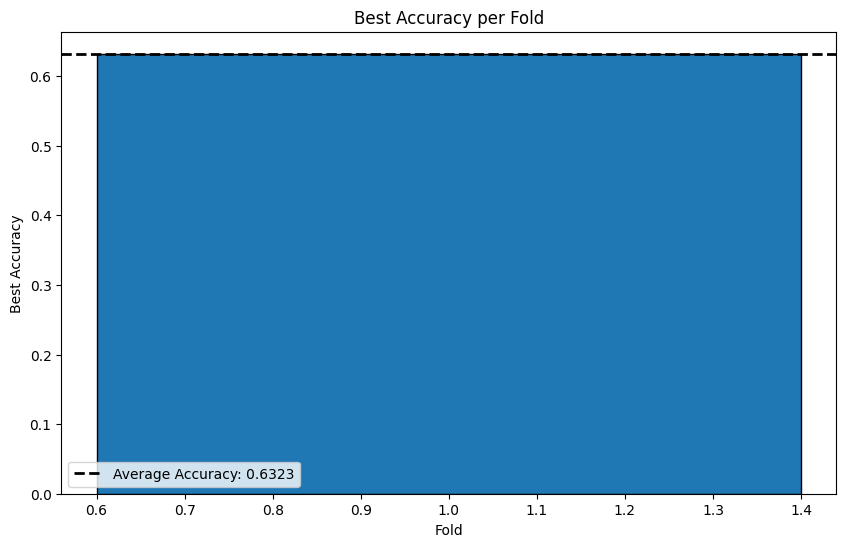

In [13]:
cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(best_accuracies)))

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(best_accuracies) + 1), best_accuracies, color=colors, edgecolor='black')
plt.axhline(y=mean_accuracy, color='black', linestyle='--', label=f'Average Accuracy: {mean_accuracy:.4f}', linewidth=2)
plt.xlabel('Fold')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy per Fold')
plt.legend()
plt.show()

### Accuracies por clase

In [14]:
# Extraer las precisiones por clase y fold
num_classes = 10 # Numero de clases
num_folds = len(folds_performance)
class_accuracies_train = np.zeros((num_folds, num_classes))
class_accuracies_val = np.zeros((num_folds, num_classes))

for i, fold_result in enumerate(folds_performance):
    train_report = fold_result['train_report']
    val_report = fold_result['val_report']
    for class_idx in range(num_classes):
        class_label = str(class_idx)
        if class_label in train_report:
            class_accuracies_train[i, class_idx] = train_report[class_label]['precision']
        if class_label in val_report:
            class_accuracies_val[i, class_idx] = val_report[class_label]['precision']
            
# Calcular el promedio por clase para entrenamiento y validación
mean_class_accuracies_train = np.mean(class_accuracies_train, axis=0)
mean_class_accuracies_val = np.mean(class_accuracies_val, axis=0)

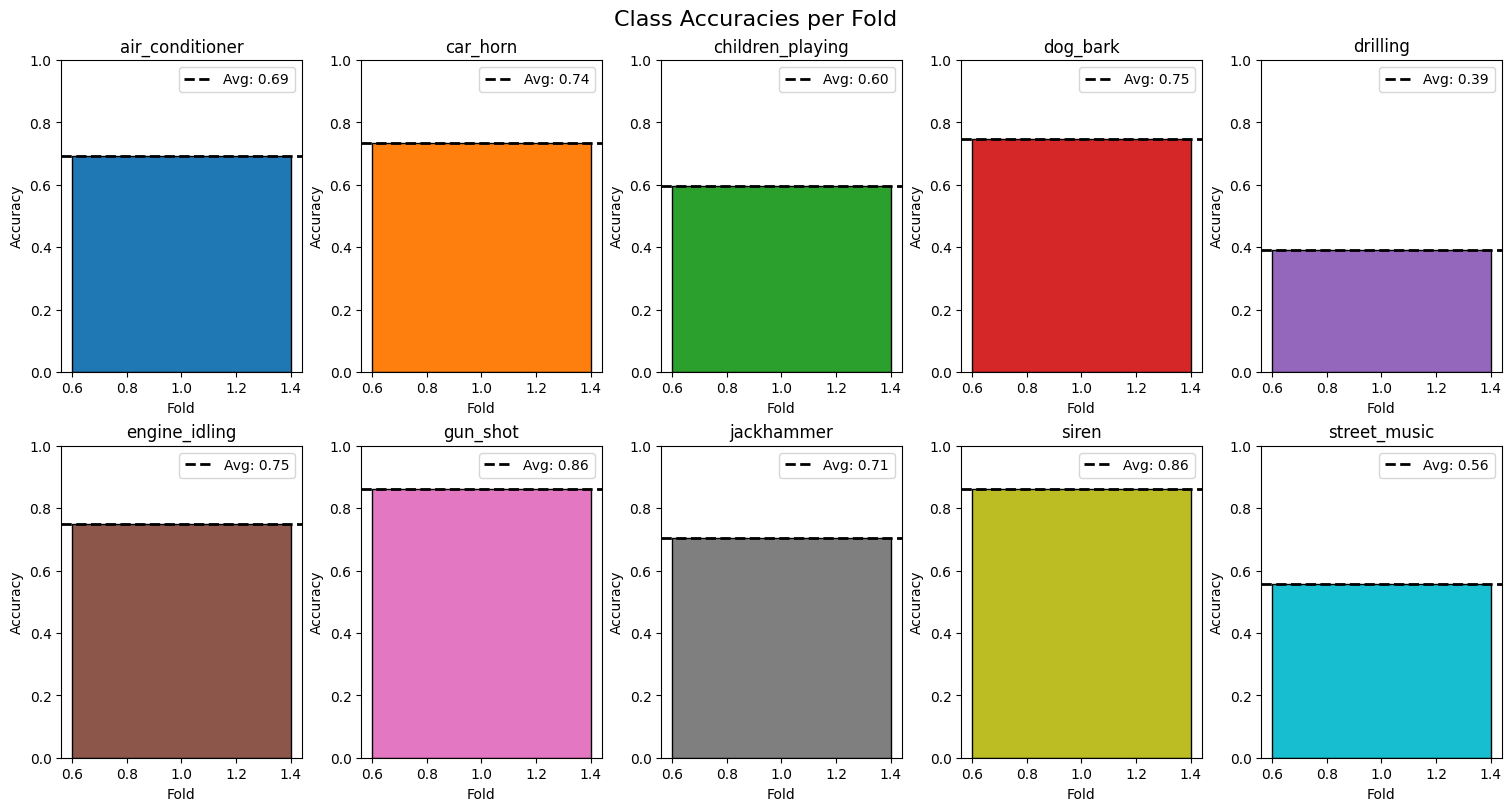

In [15]:
# Definir el layout de los subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 8), constrained_layout=True)
fig.suptitle('Class Accuracies per Fold', fontsize=16)

for class_idx in range(num_classes):
    row = class_idx // 5
    col = class_idx % 5
    ax = axs[row, col]
    
    # Accuracies de cada fold para la clase actual
    accuracies_per_fold = class_accuracies_val[:, class_idx]
    
    # Asignar un color único a todas las barras del subplot (un color distinto por subplot)
    color_option = cmap(class_idx % 10)
    
    # Mismo color para todas las barras en el subplot, pero distinto para cada clase
    ax.bar(range(1, num_folds + 1), accuracies_per_fold, color=color_option, edgecolor='black')
    
    # Línea de promedio
    avg_accuracy = mean_class_accuracies_val[class_idx]
    ax.axhline(y=avg_accuracy, color='black', linestyle='--', label=f'Avg: {avg_accuracy:.2f}', linewidth=2)
    
    # Usar el mapeo para el título de cada clase
    class_name = class_mapping.get(class_idx, f'Class {class_idx}')
    ax.set_title(class_name)
    ax.set_xlabel('Fold')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.legend()

plt.show()

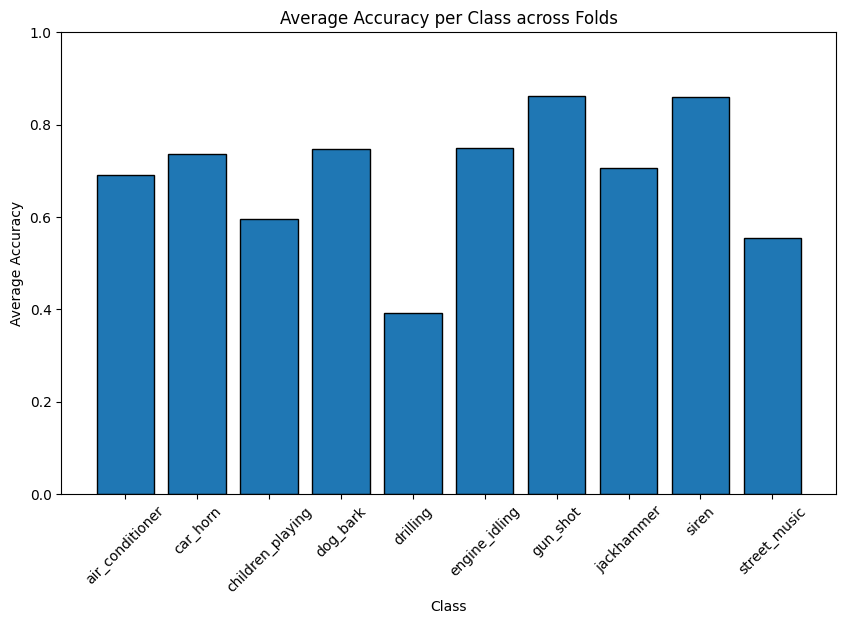

In [16]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), mean_class_accuracies_val, color=colors, edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy per Class across Folds')
plt.ylim(0, 1)

# Usar el mapeo para mostrar los nombres de las clases en el eje x
class_labels = [class_mapping.get(i, f'Class {i}') for i in range(num_classes)]
plt.xticks(range(num_classes), class_labels, rotation=45)

plt.show()

### Reportes de clasificacion

In [17]:
print("Validation Classification Report per Fold with Overall Metrics:")

for fold_result in folds_performance:
    print(f"\nFold {fold_result['fold']} - Validation Classification Report:")
    val_report = fold_result['val_report']
    
    # Mostrar métricas por clase solo con el nombre de la clase
    for label, metrics in val_report.items():
        if label.isdigit():  # Solo mostrar métricas por clase
            class_name = class_mapping.get(int(label), "Unknown Class")  # Obtener nombre de la clase
            print(f"{class_name}: Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-Score: {metrics['f1-score']:.4f}")
    
    # Mostrar métricas generales
    if 'macro avg' in val_report:
        general_metrics = val_report['macro avg']
        print("\nGeneral Metrics (Macro Average):")
        print(f"Precision: {general_metrics['precision']:.4f}, Recall: {general_metrics['recall']:.4f}, F1-Score: {general_metrics['f1-score']:.4f}")
    elif 'weighted avg' in val_report:
        general_metrics = val_report['weighted avg']
        print("\nGeneral Metrics (Weighted Average):")
        print(f"Precision: {general_metrics['precision']:.4f}, Recall: {general_metrics['recall']:.4f}, F1-Score: {general_metrics['f1-score']:.4f}")


Validation Classification Report per Fold with Overall Metrics:

Fold 1 - Validation Classification Report:
air_conditioner: Precision: 0.6909, Recall: 0.3800, F1-Score: 0.4903
car_horn: Precision: 0.7353, Recall: 0.6944, F1-Score: 0.7143
children_playing: Precision: 0.5952, Recall: 0.7500, F1-Score: 0.6637
dog_bark: Precision: 0.7477, Recall: 0.8000, F1-Score: 0.7729
drilling: Precision: 0.3913, Recall: 0.7200, F1-Score: 0.5070
engine_idling: Precision: 0.7500, Recall: 0.5312, F1-Score: 0.6220
gun_shot: Precision: 0.8611, Recall: 0.8857, F1-Score: 0.8732
jackhammer: Precision: 0.7059, Recall: 0.3000, F1-Score: 0.4211
siren: Precision: 0.8605, Recall: 0.8605, F1-Score: 0.8605
street_music: Precision: 0.5556, Recall: 0.7000, F1-Score: 0.6195

General Metrics (Macro Average):
Precision: 0.6893, Recall: 0.6622, F1-Score: 0.6544


### Historico de Perdidas

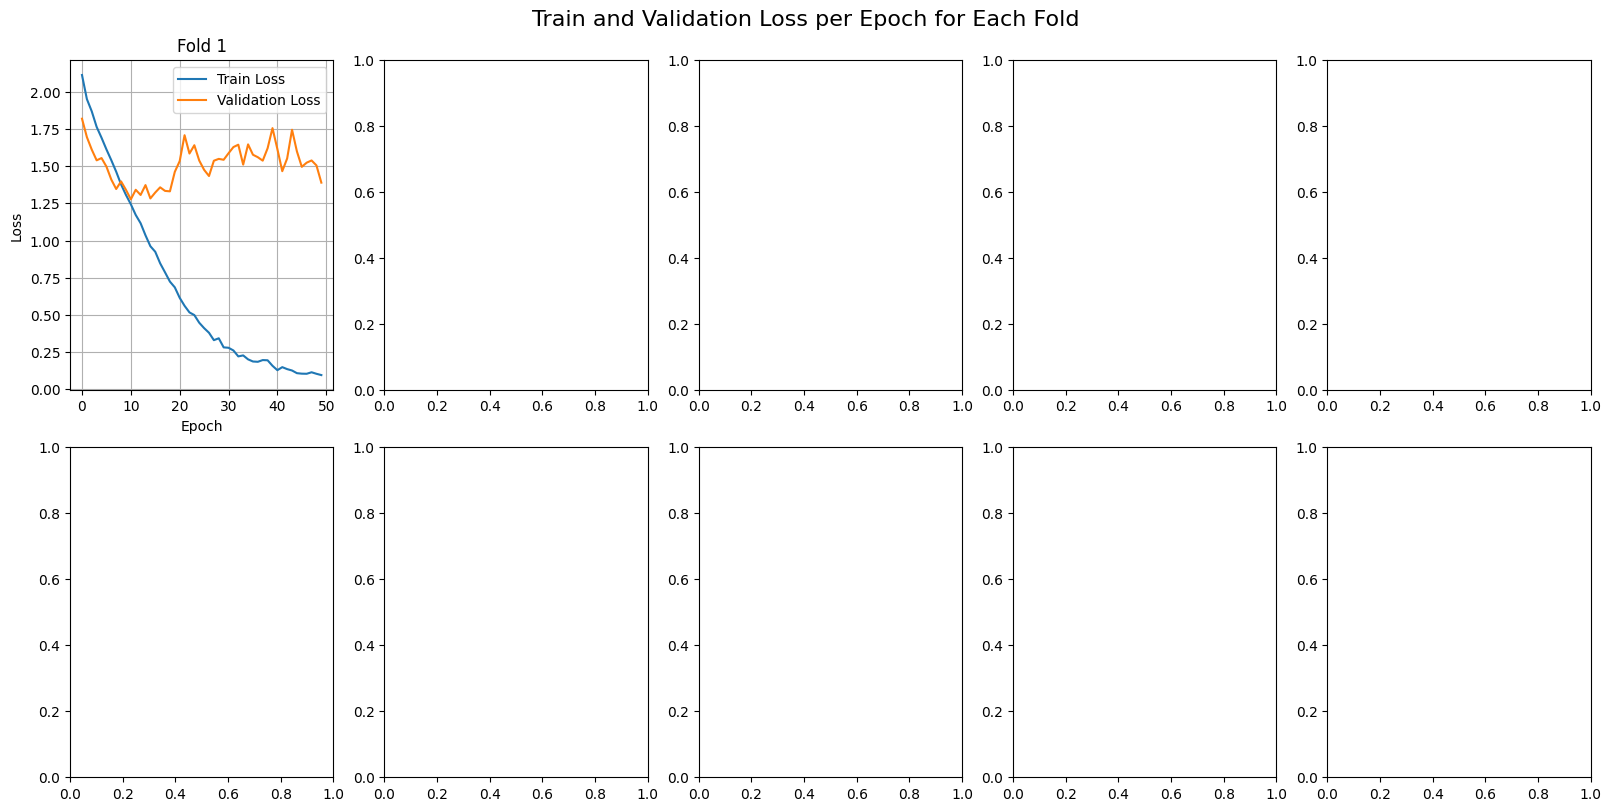

In [18]:
# Definir el número de épocas (asumiendo que todos los folds tienen la misma cantidad de épocas)
num_epochs = len(folds_performance[0]['train_losses'])

# Inicializar arrays para acumular las pérdidas de entrenamiento y validación
avg_train_losses = np.zeros(num_epochs)
avg_val_losses = np.zeros(num_epochs)

# Acumular las pérdidas de cada fold
for fold_result in folds_performance:
    avg_train_losses += np.array(fold_result['train_losses'])
    avg_val_losses += np.array(fold_result['val_losses'])

# Calcular el promedio dividiendo por el número de folds
avg_train_losses /= len(folds_performance)
avg_val_losses /= len(folds_performance)

# Crear los subplots para cada fold
fig, axs = plt.subplots(2, 5, figsize=(16, 8), constrained_layout=True)
fig.suptitle('Train and Validation Loss per Epoch for Each Fold', fontsize=16)

for i, fold_result in enumerate(folds_performance):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    
    # Extraer pérdidas de entrenamiento y validación
    train_losses = fold_result['train_losses']
    val_losses = fold_result['val_losses']
    
    # Graficar las pérdidas en el subplot correspondiente
    ax.plot(train_losses, label='Train Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_title(f'Fold {fold_result["fold"]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

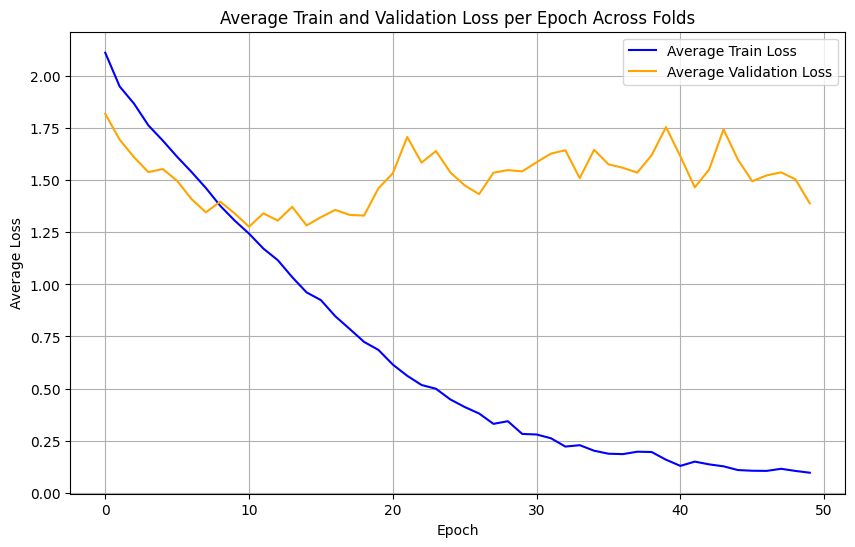

In [19]:
# Gráfico adicional para las pérdidas promedio
plt.figure(figsize=(10, 6))
plt.plot(avg_train_losses, label='Average Train Loss', color='blue')
plt.plot(avg_val_losses, label='Average Validation Loss', color='orange')
plt.title('Average Train and Validation Loss per Epoch Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

### Historico de Precisiones

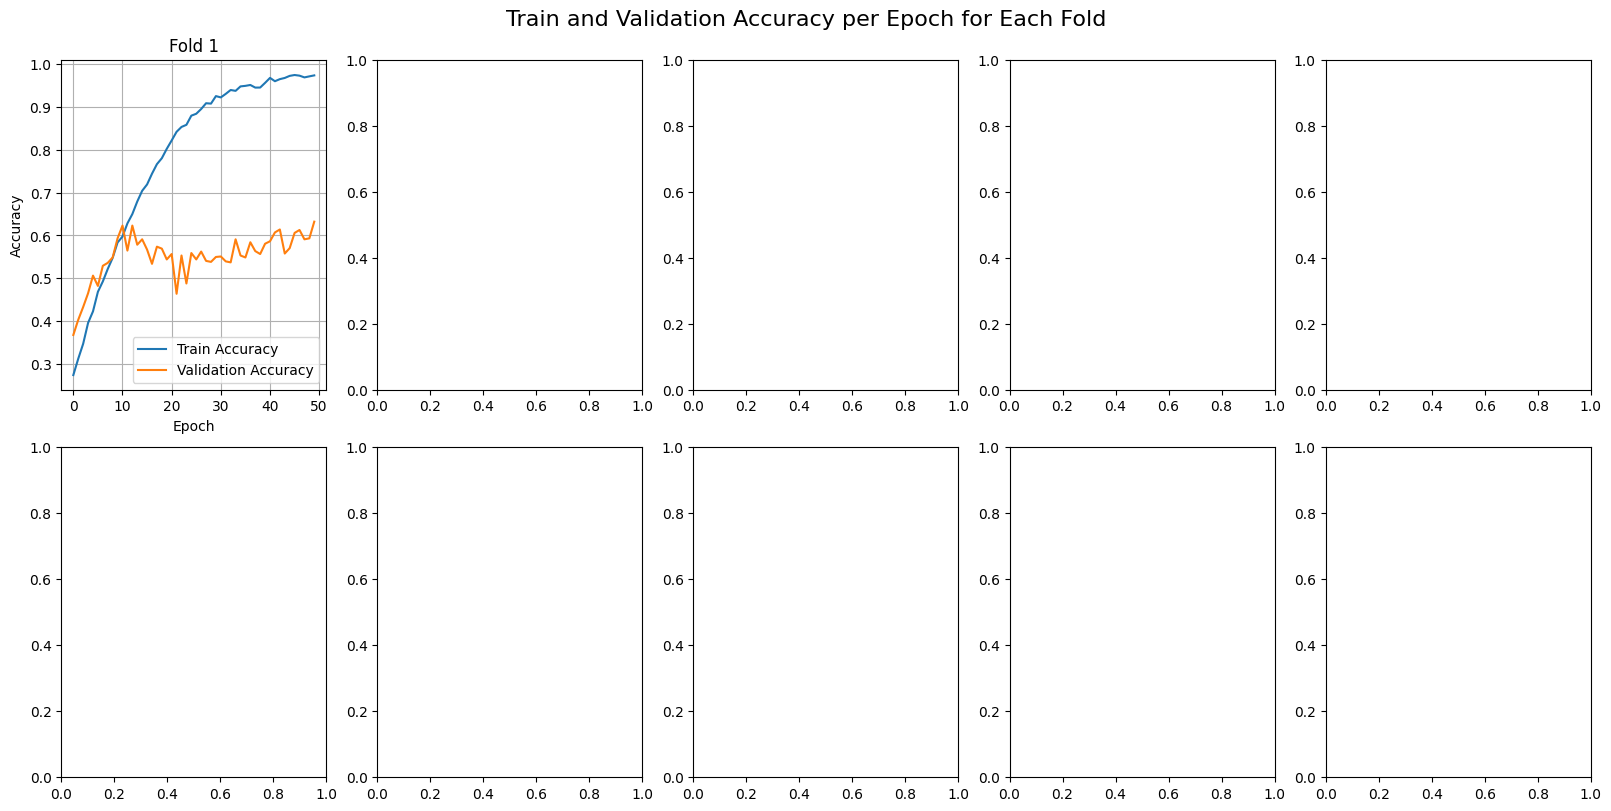

In [20]:
# Definir el número de épocas (asumiendo que todos los folds tienen la misma cantidad de épocas)
num_epochs = len(folds_performance[0]['train_accuracies'])

# Inicializar arrays para acumular las precisiones de entrenamiento y validación
avg_train_accuracies = np.zeros(num_epochs)
avg_val_accuracies = np.zeros(num_epochs)

# Acumular las precisiones de cada fold
for fold_result in folds_performance:
    avg_train_accuracies += np.array(fold_result['train_accuracies'])
    avg_val_accuracies += np.array(fold_result['val_accuracies'])

# Calcular el promedio dividiendo por el número de folds
avg_train_accuracies /= len(folds_performance)
avg_val_accuracies /= len(folds_performance)

# Crear los subplots para cada fold
fig, axs = plt.subplots(2, 5, figsize=(16, 8), constrained_layout=True)
fig.suptitle('Train and Validation Accuracy per Epoch for Each Fold', fontsize=16)

for i, fold_result in enumerate(folds_performance):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    
    # Extraer precisiones de entrenamiento y validación
    train_accuracies = fold_result['train_accuracies']
    val_accuracies = fold_result['val_accuracies']
    
    # Graficar las precisiones en el subplot correspondiente
    ax.plot(train_accuracies, label='Train Accuracy')
    ax.plot(val_accuracies, label='Validation Accuracy')
    ax.set_title(f'Fold {fold_result["fold"]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

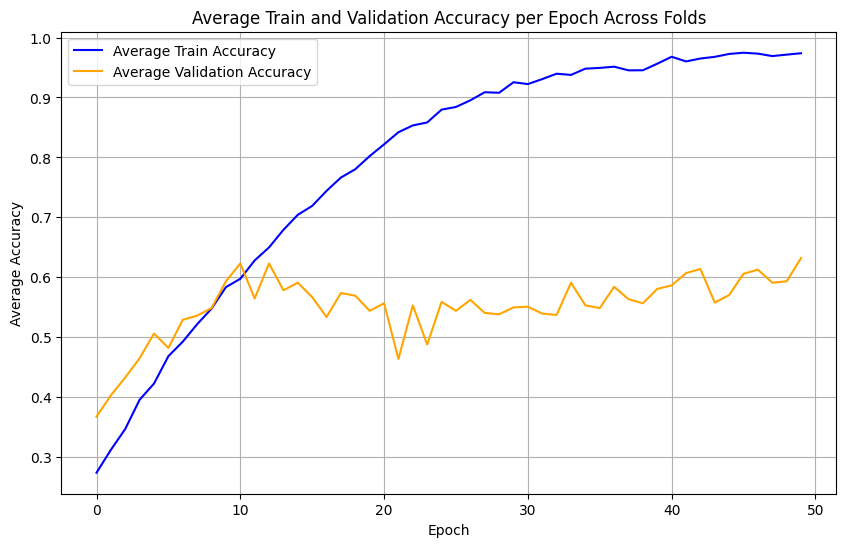

In [21]:
# Gráfico adicional para las precisiones promedio
plt.figure(figsize=(10, 6))
plt.plot(avg_train_accuracies, label='Average Train Accuracy', color='blue')
plt.plot(avg_val_accuracies, label='Average Validation Accuracy', color='orange')
plt.title('Average Train and Validation Accuracy per Epoch Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Matrices de Confusion

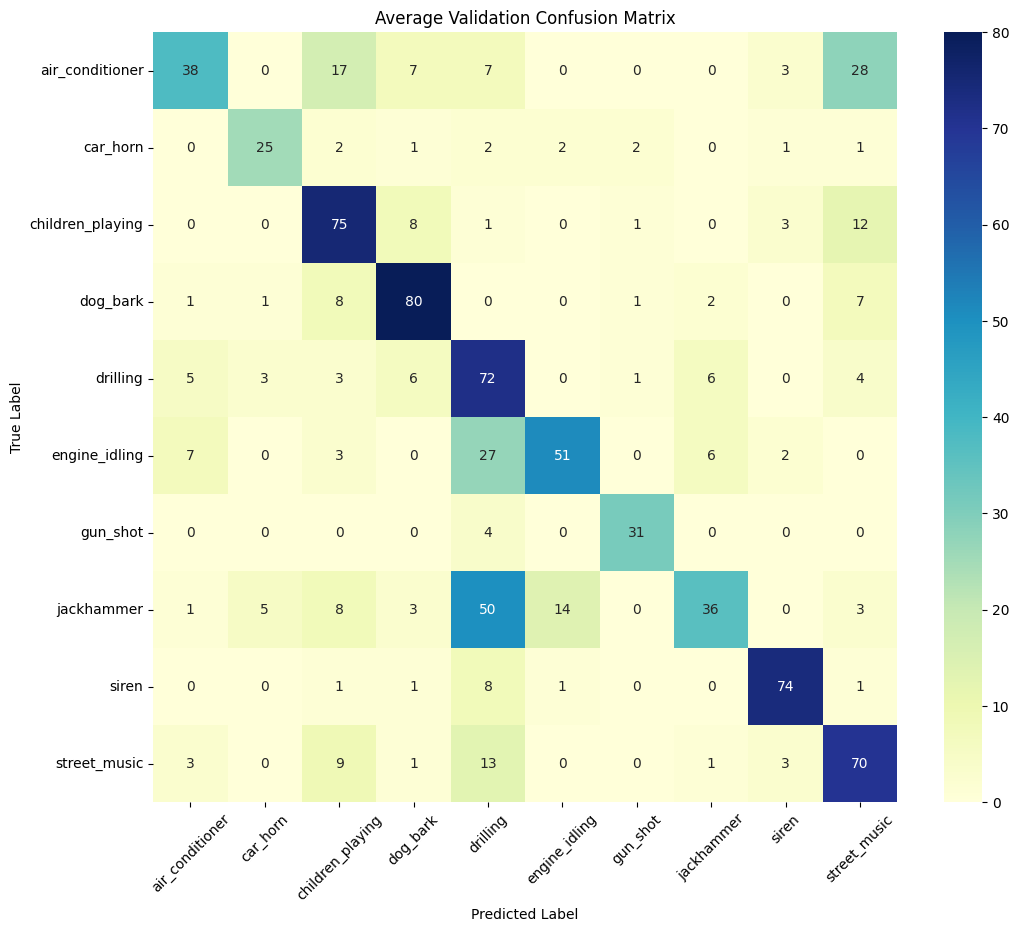

In [22]:
# Inicializar una matriz para acumular las matrices de confusión de validación
num_classes = folds_performance[0]['val_matrix'].shape[0]
avg_conf_matrix = np.zeros((num_classes, num_classes), dtype=float)

# Acumular las matrices de confusión de cada fold
for fold_result in folds_performance:
    avg_conf_matrix += fold_result['val_matrix']

# Calcular el promedio dividiendo por el número de folds
avg_conf_matrix /= len(folds_performance)

# Obtener las etiquetas de clase usando el mapeo
class_labels = [class_mapping[i] for i in range(num_classes)]

# Graficar la matriz de confusión promedio
plt.figure(figsize=(12, 10))
sns.heatmap(avg_conf_matrix, annot=True, cmap="YlGnBu", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Average Validation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.ylabel("True Label")
plt.show()